# Decompose an example function with differing Sobol indices

In [42]:
%run imports.py

seed = 4
np.random.seed(seed)
tf.random.set_seed(seed)

All packages loaded successfully.


In [43]:
X = np.random.normal(1.2, 1, size=(1000,2))
y1 = np.exp(-(X[:,0]-1.2)**2)
y2 = np.exp(-(X[:,1]+1.2)**2)

xeval = np.linspace(-10,10, 1000)
y1_eval = np.exp(-(xeval-1.2)**2)
y2_eval = np.exp(-(xeval+1.2)**2)

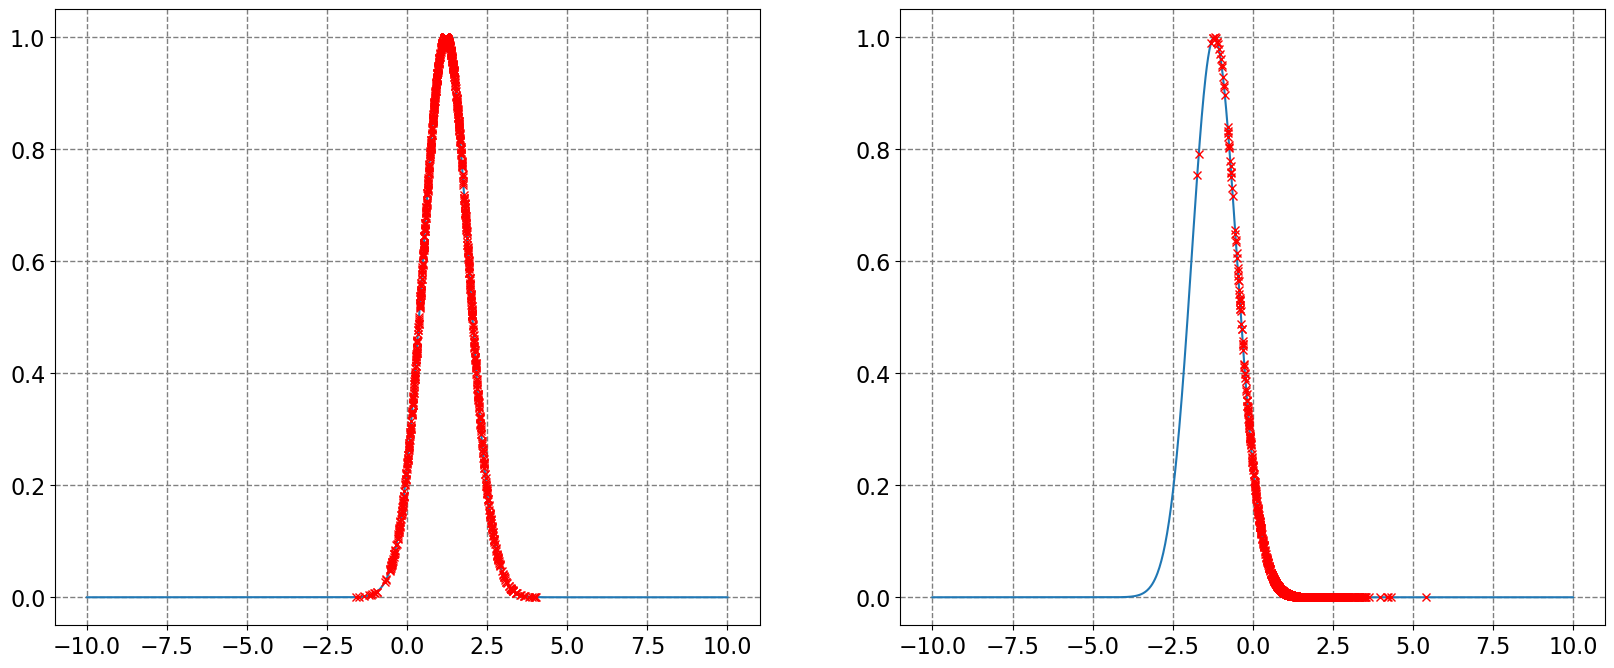

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(xeval, y1_eval)
axes[0].plot(X[:,0], y1, 'x', color='red')
axes[0].grid('on')


axes[1].plot(xeval, y2_eval)
axes[1].plot(X[:,1], y2, 'x', color='red')
axes[1].grid('on')

In [47]:
# --- Generate synthetic 2D data ---
def true_function(X):
    x1, x2 = X[:,0], X[:,1]
    return np.exp(-(x1-1.2)**2) + np.exp(-(x2+1.2)**2)

n = 1000
noise = 0.01
X = np.random.normal(1.2, 1, size=(n,2))
y = true_function(X) + np.random.normal(0, noise, size=n)

y = y.reshape(-1, 1)
y_mean, y_std = np.mean(y), np.std(y)
y = (y - y_mean) / y_std

true_f1 = lambda x: np.exp(-(x-1.2)**2)
true_f2 = lambda x: np.exp(-(x+1.2)**2)

In [48]:
print("OAK with a Gaussian Measure N(1.2,1) ...")
custom_measure = MOGMeasure(means=np.array([1.2]), variances=np.array([1.0]), weights=np.array([1.0]))
gmm_measures_list = [custom_measure, custom_measure]


# --- Create AGP model ---
data = (X, y)
model = create_model_oak(
         data=data,
         max_interaction_depth=2,
         constrain_orthogonal=True,
         share_var_across_orders=True,
         use_sparsity_prior=False,
         gmm_measures=gmm_measures_list,
)
for i in range(X.shape[1]):
    model.kernel.kernels[i].base_kernel.variance.assign(1.0)
    gpflow.set_trainable(model.kernel.kernels[i].base_kernel.variance, False)


# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))


# --- Print model summary ---
gpflow.utilities.print_summary(model)
print(model.training_loss().numpy())




print("OAK with a Gaussian Measure N(-1.2,1) ...")
custom_measure = MOGMeasure(means=np.array([-1.2]), variances=np.array([1.0]), weights=np.array([1.0]))
gmm_measures_list = [custom_measure, custom_measure]


# --- Create AGP model ---
data = (X, y)
model1 = create_model_oak(
         data=data,
         max_interaction_depth=2,
         constrain_orthogonal=True,
         share_var_across_orders=True,
         use_sparsity_prior=False,
         gmm_measures=gmm_measures_list,
)
for i in range(X.shape[1]):
    model1.kernel.kernels[i].base_kernel.variance.assign(1.0)
    gpflow.set_trainable(model1.kernel.kernels[i].base_kernel.variance, False)


# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model1.training_loss, model1.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))


# --- Print model summary ---
gpflow.utilities.print_summary(model1)
print(model1.training_loss().numpy())

OAK with a Gaussian Measure N(1.2,1) ...
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].base_kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1           │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.977027    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼────

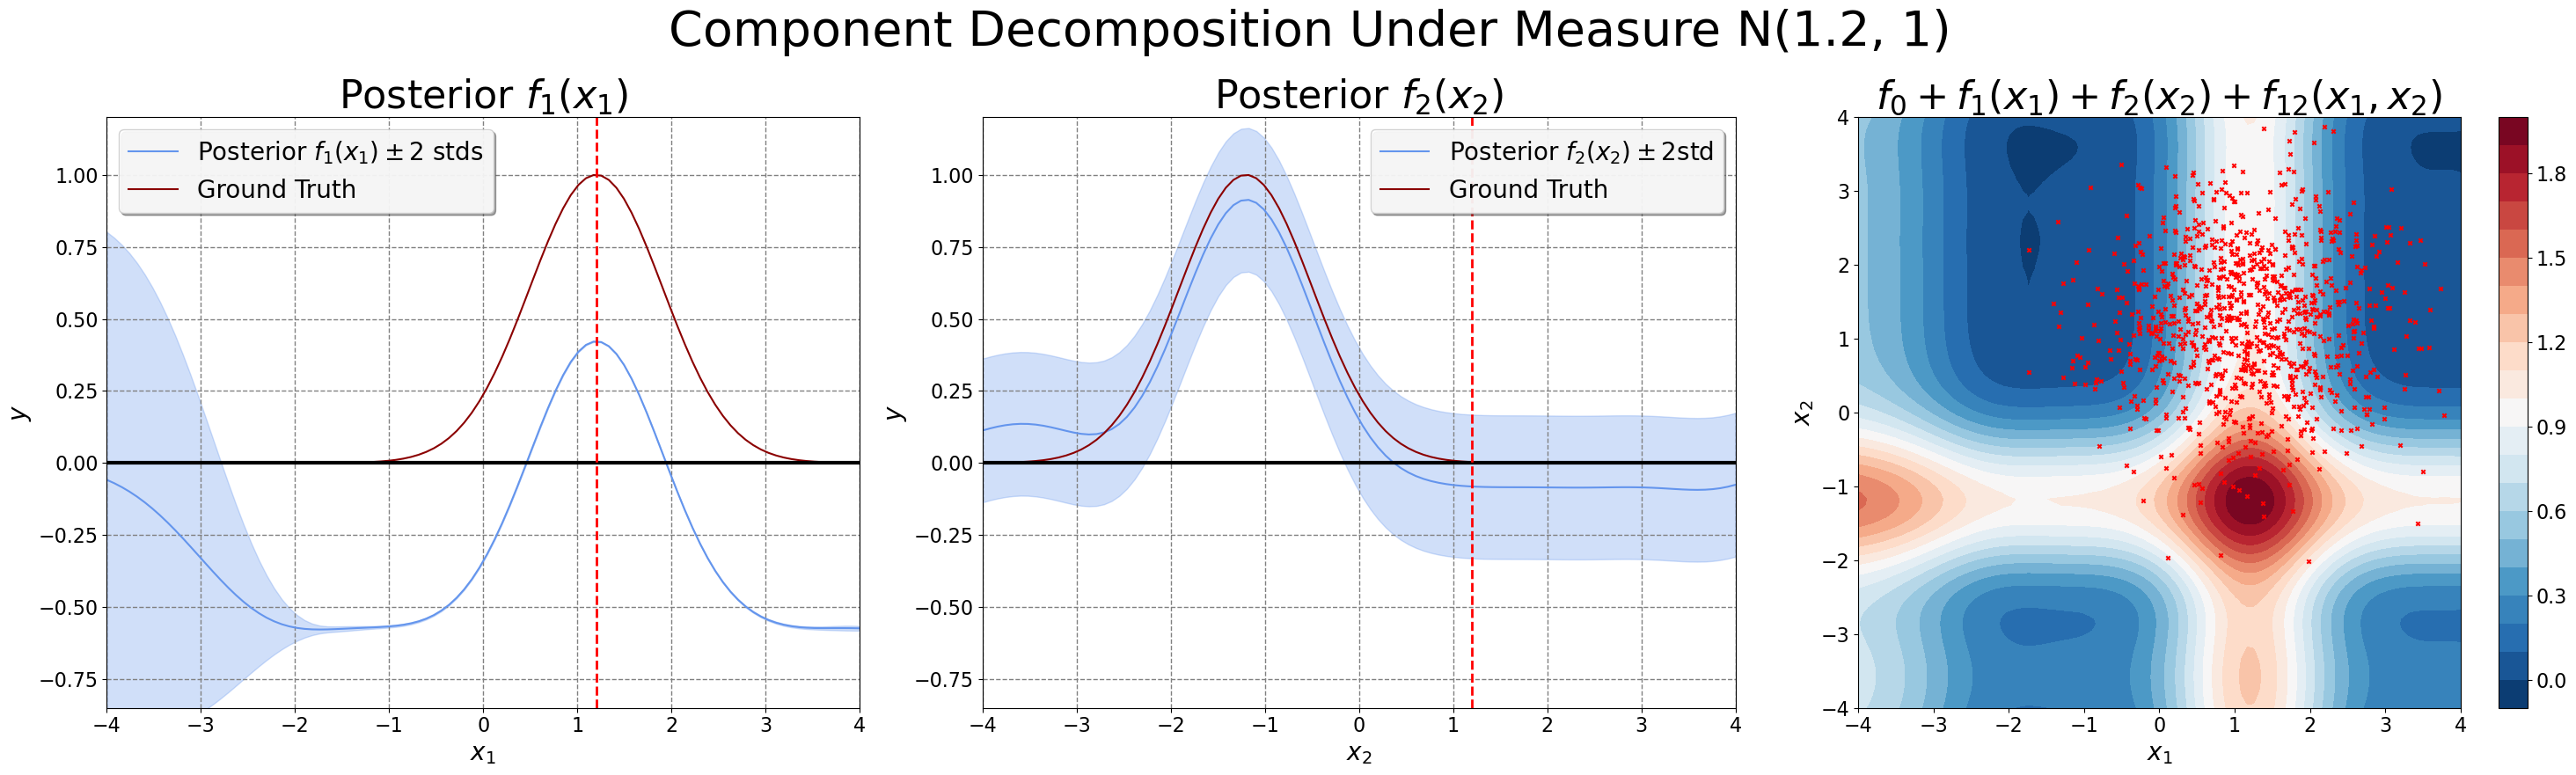

In [49]:
N = 10000
X_samples = np.random.normal(0, 1, size=(N, 2))
X_train = model.data[0].numpy()
alpha = get_model_sufficient_statistics(model, get_L=False)
selected_dims, kernel_list = get_list_representation(model.kernel, num_dims=2)



# --- Meshgrid for plotting ---
lb = -4
ub = 4
x1_plot = np.linspace(lb, ub, 100)
x2_plot = np.linspace(lb, ub, 100)
X1_grid, X2_grid = np.meshgrid(x1_plot, x2_plot)
X_grid = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)
X_grid_tf = tf.convert_to_tensor(X_grid, dtype=tf.float64)
X_grid_f1 = np.stack([X1_grid.ravel(), np.zeros_like(X1_grid).ravel()], axis=1)
X_grid_f1_tf = tf.convert_to_tensor(X_grid_f1, dtype=tf.float64)
X_grid_f2 = np.stack([np.zeros_like(X2_grid).ravel(), X2_grid.ravel()], axis=1)
X_grid_f2_tf = tf.convert_to_tensor(X_grid_f2, dtype=tf.float64)


# --- Build inputs with fixed variables for f1 and f2 ---
X_plot_f1 = np.copy(X_grid)
X_plot_f1[:, 1] = 0
X_plot_f2 = np.copy(X_grid)
X_plot_f2[:, 0] = 0
X_plot_f12 = X_grid


# --- Evaluate function ---
f0_vals = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f1_vals = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(X_plot_f1, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f2_vals = eval_component(kernel_list[2], alpha, tf.convert_to_tensor(X_plot_f2, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f12_vals = eval_component(kernel_list[3], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)


# --- Posterior Variances ---
K_yy = model.kernel.K(X_train, X_train) + tf.eye(len(X_train), dtype=tf.float64) * model.likelihood.variance.numpy()

# Variance for f0
var_f0_tensor = get_component_variance(kernel_list[0], K_yy, X_grid_tf, X_train)
var_f0 = var_f0_tensor.numpy().reshape(100, 100)
std_f0 = np.sqrt(var_f0) * y_std

# Variance for f1
var_f1_tensor = get_component_variance(kernel_list[1], K_yy, X_grid_f1_tf, X_train)
var_f1 = var_f1_tensor.numpy().reshape(100, 100)
std_f1 = np.sqrt(np.mean(var_f1, axis=0)) * y_std

# Variance for f2
var_f2_tensor = get_component_variance(kernel_list[2], K_yy, X_grid_f2_tf, X_train)
var_f2 = var_f2_tensor.numpy().reshape(100, 100)
std_f2 = np.sqrt(np.mean(var_f2, axis=0)) * y_std

# Variance for f12
var_f12_tensor = get_component_variance(kernel_list[3], K_yy, X_grid_tf, X_train)
var_f12 = var_f12_tensor.numpy().reshape(100, 100)
std_f12 = np.sqrt(var_f12) * y_std

# Variance for the overall model
var_overall_tensor = get_component_variance(model.kernel, K_yy, X_grid_tf, X_train)
var_overall = var_overall_tensor.numpy().reshape(100, 100)
std_overall = np.sqrt(var_overall) * y_std



# --- Denorrmalise ---
f_sum = (f0_vals + f1_vals + f2_vals + f12_vals) * y_std + y_mean
f0_vals = f0_vals * y_std + y_mean
f1_vals = f1_vals * y_std
f2_vals = f2_vals * y_std
f12_vals = f12_vals * y_std
f_true = true_function(X_grid).reshape(100,100)


# --- 1D plots of f1(x1), f2(x2) ---
f1_x1 = np.mean(f1_vals, axis=0)
f1_true = true_f1(x1_plot)
f2_x2 = np.mean(f2_vals, axis=1)
f2_true = true_f2(x2_plot)

f12_x1 = np.mean(f12_vals, axis=0)
f12_x2 = np.mean(f12_vals, axis=1)


# --- Plot the results ---
fig, axes = plt.subplots(1, 3, figsize=(30, 9))

# f1
axes[0].plot(x1_plot, f1_x1, label='Posterior $f_1(x_1) \\pm 2$ stds', color='cornflowerblue')
axes[0].fill_between(x1_plot, f1_x1 - 2*std_f1, f1_x1 + 2*std_f1, color='cornflowerblue', alpha=0.3)
axes[0].plot(x1_plot, f1_true, label='Ground Truth', color='darkred')
axes[0].axhline(y=0, linewidth=3, linestyle='-', color='black')
axes[0].axvline(x=1.2, linewidth=2, linestyle='--', color='red')
axes[0].set_title("Posterior $f_1(x_1)$")
axes[0].set_xlim([lb,ub])
axes[0].set_ylim([-0.85, 1.2])
axes[0].grid(True)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$y$')
axes[0].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)


# f2
axes[1].plot(x2_plot, f2_x2, label='Posterior $f_2(x_2) \\pm 2$std', color='cornflowerblue')
axes[1].fill_between(x2_plot, f2_x2 - 2*std_f2, f2_x2 + 2*std_f2, color='cornflowerblue', alpha=0.3)
axes[1].plot(x2_plot, f2_true, label='Ground Truth', color='darkred')
axes[1].axhline(y=0, linewidth=3, linestyle='-', color='black')
axes[1].axvline(x=1.2, linewidth=2, linestyle='--', color='red')
axes[1].set_title("Posterior $f_2(x_2)$")
axes[1].set_xlim([lb,ub])
axes[1].set_ylim([-0.85, 1.2])
axes[1].grid(True)
axes[1].set_xlabel('$x_2$')
axes[1].set_ylabel('$y$')
axes[1].legend(loc='upper right', frameon=True, shadow=True, fancybox=True, framealpha=0.9)


# f_total
cont2 = axes[2].contourf(X1_grid, X2_grid, f_sum, levels=20, cmap='RdBu_r')
axes[2].set_title("$f_0 + f_1(x_1) + f_2(x_2) + f_{12}(x_1,x_2)$")
axes[2].scatter(X[:, 0], X[:, 1], c='red', s=10, marker='x', label='Training Data')
fig.colorbar(cont2, ax=axes[2])
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_xlim([lb,ub])
axes[2].set_ylim([lb,ub])

fig.suptitle('Component Decomposition Under Measure N(1.2, 1)', fontsize=40)


plt.tight_layout()
plt.show()

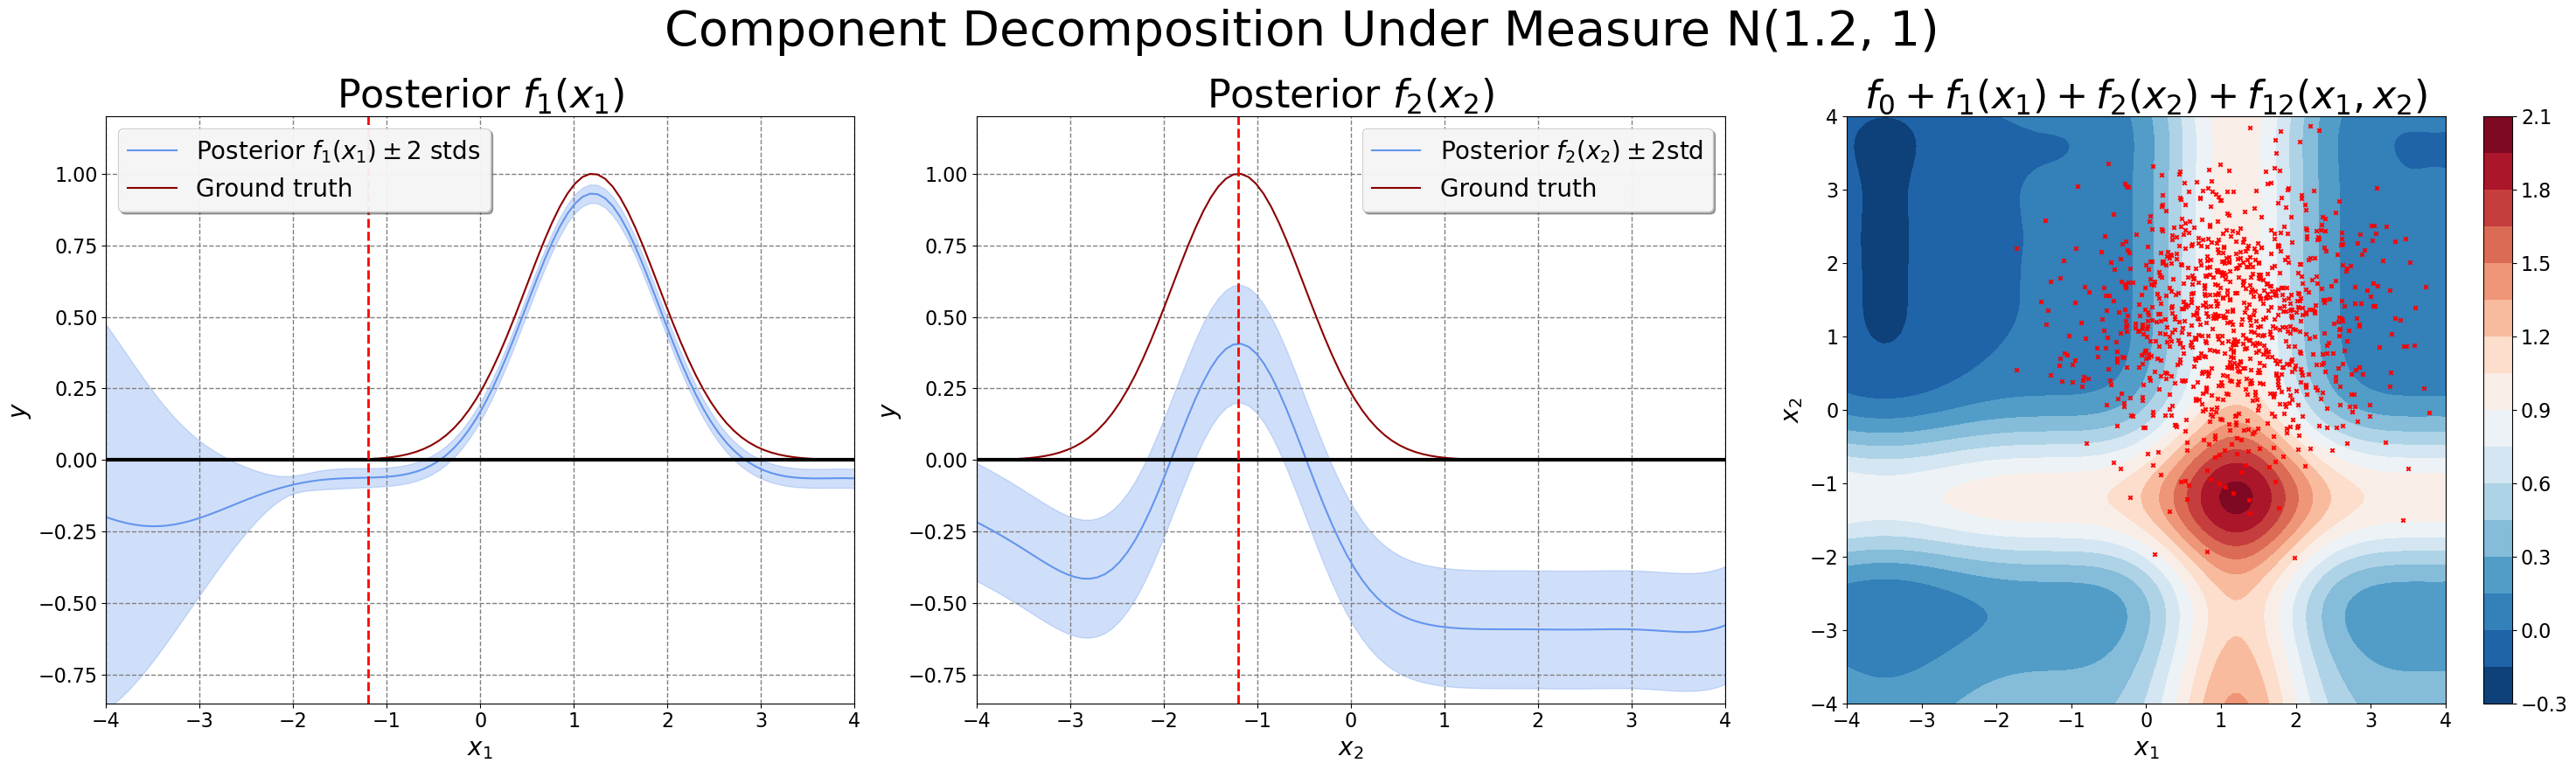

In [52]:
N = 10000
X_samples = np.random.normal(0, 1, size=(N, 2))
X_train = model1.data[0].numpy()
alpha = get_model_sufficient_statistics(model1, get_L=False)
selected_dims, kernel_list = get_list_representation(model1.kernel, num_dims=2)



# --- Meshgrid for plotting ---
lb = -4
ub = 4
x1_plot = np.linspace(lb, ub, 100)
x2_plot = np.linspace(lb, ub, 100)
X1_grid, X2_grid = np.meshgrid(x1_plot, x2_plot)
X_grid = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)
X_grid_tf = tf.convert_to_tensor(X_grid, dtype=tf.float64)
X_grid_f1 = np.stack([X1_grid.ravel(), np.zeros_like(X1_grid).ravel()], axis=1)
X_grid_f1_tf = tf.convert_to_tensor(X_grid_f1, dtype=tf.float64)
X_grid_f2 = np.stack([np.zeros_like(X2_grid).ravel(), X2_grid.ravel()], axis=1)
X_grid_f2_tf = tf.convert_to_tensor(X_grid_f2, dtype=tf.float64)


# --- Build inputs with fixed variables for f1 and f2 ---
X_plot_f1 = np.copy(X_grid)
X_plot_f1[:, 1] = 0
X_plot_f2 = np.copy(X_grid)
X_plot_f2[:, 0] = 0
X_plot_f12 = X_grid


# --- Evaluate function ---
f0_vals = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f1_vals = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(X_plot_f1, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f2_vals = eval_component(kernel_list[2], alpha, tf.convert_to_tensor(X_plot_f2, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f12_vals = eval_component(kernel_list[3], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)


# --- Posterior Variances ---
K_yy = model1.kernel.K(X_train, X_train) + tf.eye(len(X_train), dtype=tf.float64) * model.likelihood.variance.numpy()

# Variance for f0
var_f0_tensor = get_component_variance(kernel_list[0], K_yy, X_grid_tf, X_train)
var_f0 = var_f0_tensor.numpy().reshape(100, 100)
std_f0 = np.sqrt(var_f0) * y_std

# Variance for f1
var_f1_tensor = get_component_variance(kernel_list[1], K_yy, X_grid_f1_tf, X_train)
var_f1 = var_f1_tensor.numpy().reshape(100, 100)
std_f1 = np.sqrt(np.mean(var_f1, axis=0)) * y_std

# Variance for f2
var_f2_tensor = get_component_variance(kernel_list[2], K_yy, X_grid_f2_tf, X_train)
var_f2 = var_f2_tensor.numpy().reshape(100, 100)
std_f2 = np.sqrt(np.mean(var_f2, axis=0)) * y_std

# Variance for f12
var_f12_tensor = get_component_variance(kernel_list[3], K_yy, X_grid_tf, X_train)
var_f12 = var_f12_tensor.numpy().reshape(100, 100)
std_f12 = np.sqrt(var_f12) * y_std

# Variance for the overall model
var_overall_tensor = get_component_variance(model1.kernel, K_yy, X_grid_tf, X_train)
var_overall = var_overall_tensor.numpy().reshape(100, 100)
std_overall = np.sqrt(var_overall) * y_std



# --- Denorrmalise ---
f_sum = (f0_vals + f1_vals + f2_vals + f12_vals) * y_std + y_mean
f0_vals = f0_vals * y_std + y_mean
f1_vals = f1_vals * y_std
f2_vals = f2_vals * y_std
f12_vals = f12_vals * y_std
f_true = true_function(X_grid).reshape(100,100)


# --- 1D plots of f1(x1), f2(x2) ---
f1_x1 = np.mean(f1_vals, axis=0)
f1_true = true_f1(x1_plot)
f2_x2 = np.mean(f2_vals, axis=1)
f2_true = true_f2(x2_plot)


f12_x1 = np.mean(f12_vals, axis=0)
f12_x2 = np.mean(f12_vals, axis=1)


fig, axes = plt.subplots(1, 3, figsize=(30, 9))

# f1
axes[0].plot(x1_plot, f1_x1, label='Posterior $f_1(x_1) \\pm 2$ stds', color='cornflowerblue')
axes[0].fill_between(x1_plot, f1_x1 - 2*std_f1, f1_x1 + 2*std_f1, color='cornflowerblue', alpha=0.3)
axes[0].plot(x1_plot, f1_true, label='Ground truth', color='darkred')
axes[0].axhline(y=0, linewidth=3, linestyle='-', color='black')
axes[0].axvline(x=-1.2, linewidth=2, linestyle='--', color='red')
axes[0].set_title("Posterior $f_1(x_1)$")
axes[0].set_xlim([lb,ub])
axes[0].set_ylim([-0.85, 1.2])
axes[0].grid(True)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$y$')
axes[0].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)


# f2
axes[1].plot(x2_plot, f2_x2, label='Posterior $f_2(x_2) \\pm 2$std', color='cornflowerblue')
axes[1].fill_between(x2_plot, f2_x2 - 2*std_f2, f2_x2 + 2*std_f2, color='cornflowerblue', alpha=0.3)
axes[1].plot(x2_plot, f2_true, label='Ground truth', color='darkred')
axes[1].axhline(y=0, linewidth=3, linestyle='-', color='black')
axes[1].axvline(x=-1.2, linewidth=2, linestyle='--', color='red')
axes[1].set_title("Posterior $f_2(x_2)$")
axes[1].set_xlim([lb,ub])
axes[1].set_ylim([-0.85, 1.2])
axes[1].grid(True)
axes[1].set_xlabel('$x_2$')
axes[1].set_ylabel('$y$')
axes[1].legend(loc='upper right', frameon=True, shadow=True, fancybox=True, framealpha=0.9)


# f_total
cont2 = axes[2].contourf(X1_grid, X2_grid, f_sum, levels=20, cmap='RdBu_r')
axes[2].set_title("$f_0 + f_1(x_1) + f_2(x_2) + f_{12}(x_1,x_2)$")
axes[2].scatter(X[:, 0], X[:, 1], c='red', s=10, marker='x', label='Training Data')
fig.colorbar(cont2, ax=axes[2])
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_xlim([lb,ub])
axes[2].set_ylim([lb,ub])



fig.suptitle('Component Decomposition Under Measure N(1.2, 1)', fontsize=40)


plt.tight_layout()
plt.show()